In [1]:
import jax
from jax import numpy as np
from jax import scipy as sp
from jax import random

from numpy.polynomial.hermite import hermgauss

import scipy.cluster.hierarchy as sch

import paragami

# regression-mixture libraries
from bnpreg_runjingdev import genomics_data_utils
from bnpreg_runjingdev import regression_mixture_lib
from bnpreg_runjingdev import regression_posterior_quantities as reg_posterior_quantities

import regression_plotting_utils

# BNP libraries
from bnpmodeling_runjingdev import result_loading_utils

import matplotlib.pyplot as plt
%matplotlib inline

/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [2]:
import numpy as onp

# Load data

In [3]:
# Set bnp_data_repo to be the location of a clone of the repo
# https://github.com/NelleV/genomic_time_series_bnp
bnp_data_repo = '../../../genomic_time_series_bnp' 

genome_data, timepoints, regressors, beta, beta_infos, y_infos = \
    genomics_data_utils.load_data_and_run_regressions(bnp_data_repo)
n_genes = genome_data.shape[0]
reg_dim = regressors.shape[1]

n_timepoints = len(np.unique(timepoints))

Loading data from:  ../../../genomic_time_series_bnp/data/shoemaker2015reprocessed


# Load fits

In [4]:
out_folder = '../fits/'
out_filename = 'mice_genomics_fit'
alpha0 = 6.0

In [5]:
gmm_result_loader = result_loading_utils.FunctionalRefitsLoader(alpha0, 
                                     out_folder, 
                                     out_filename)

loading initial fit from:  ../fits/mice_genomics_fit_alpha6.0.npz
loading lr derivatives from:  ../fits/mice_genomics_fit_alpha6.0_lrderivatives.npz


### Some meta data and model parameters

In [6]:
vb_init_free = gmm_result_loader.vb_init_free
vb_params_paragami = gmm_result_loader.vb_params_paragami
vb_init_dict = vb_params_paragami.fold(vb_init_free, free = True)

In [7]:
print(vb_params_paragami)

OrderedDict:
	[stick_params] = OrderedDict:
	[stick_means] = NumericArrayPattern (39,) (lb=-inf, ub=inf)
	[stick_infos] = NumericArrayPattern (39,) (lb=0.0001, ub=inf)
	[centroids] = NumericArrayPattern (40, 10) (lb=-inf, ub=inf)
	[data_info] = NumericArrayPattern (1,) (lb=0.0, ub=inf)


In [8]:
# gauss-hermite parameters
gh_deg = int(gmm_result_loader.init_fit_meta_data['gh_deg'])
gh_loc, gh_weights = hermgauss(gh_deg)

gh_loc = np.array(gh_loc)
gh_weights = np.array(gh_weights)
    
# load prior parameters
prior_params_dict, prior_params_paragami = regression_mixture_lib.get_default_prior_params()

# set initial alpha
assert alpha0 == gmm_result_loader.init_fit_meta_data['dp_prior_alpha']
prior_params_dict['dp_prior_alpha'] = alpha0

print(prior_params_dict)

{'dp_prior_alpha': 6.0, 'prior_centroid_mean': DeviceArray([0.], dtype=float64), 'prior_centroid_info': DeviceArray([0.1], dtype=float64), 'prior_shift_mean': DeviceArray([0.], dtype=float64), 'prior_shift_info': DeviceArray([0.1], dtype=float64), 'prior_data_info_shape': DeviceArray([10.], dtype=float64), 'prior_data_info_scale': DeviceArray([0.1], dtype=float64)}


### Initial ezs

In [9]:
ez_init = reg_posterior_quantities.get_optimal_local_params_from_vb_dict(genome_data, regressors,
                                                   vb_init_dict,
                                                   prior_params_dict, 
                                                   gh_loc, gh_weights)[0]

e_num_obs_per_cluster = ez_init.sum(0)
mixture_weights = reg_posterior_quantities.get_e_mixture_weights_from_vb_dict(vb_init_dict, gh_loc, gh_weights)

In [10]:
# for better plotting later, cluster the ez's
link = sch.linkage(ez_init, method='average')
ez_perm = sch.dendrogram(link, no_plot=True)["leaves"]

### make some plots of initial fit

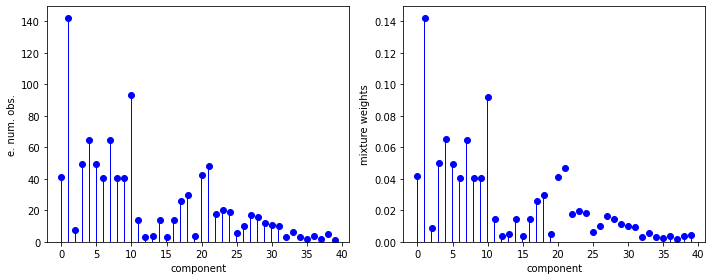

In [11]:
fig, axarr = plt.subplots(1, 2, figsize = (10, 4))

result_loading_utils._plot_weights(e_num_obs_per_cluster, 
                                   axarr[0])

result_loading_utils._plot_weights(mixture_weights, 
                                   axarr[1])


axarr[0].set_ylabel('e. num. obs.')
axarr[1].set_ylabel('mixture weights')
    
fig.tight_layout()


In [12]:
def plot_top_clusters(vb_params_dict, ez): 
    
    ##############
    # Get estimates
    ##############
    
    top_clusters_sorted = np.argsort(-e_num_obs_per_cluster)
    
    # centroids
    est_centroids = vb_params_dict['centroids']
    
    # shifts
    est_shifts = reg_posterior_quantities.get_optimal_local_params_from_vb_dict(genome_data,
                                                                            regressors,
                                                                            vb_params_dict,
                                                                            prior_params_dict, 
                                                                            gh_loc, gh_weights)[2]
    
    # average observations across replicates 
    # for plotting
    mean_operator = onp.zeros((genome_data.shape[1], n_timepoints))
    for i in range(n_timepoints): 
        mean_operator[3*i:((i+1)*3), i] = 1/3

    unique_timepoints = np.unique(timepoints)
    _y = np.dot(genome_data, mean_operator)
    
    
    ###############
    # PLOT
    ###############
    f, axarr = plt.subplots(2, 3, figsize=(15,8))

    for i in range(6):
        which_cluster = top_clusters_sorted[i]

        # genes in this cluster
        which_genes = np.argwhere(ez.argmax(1) == which_cluster).squeeze()

        this_plot = axarr[int(np.floor(i / 3)), i % 3]

        this_plot.set_title('cluster = {}; num. genes = {}'.format(which_cluster, len(which_genes)))
        this_plot.set_xlabel('time')
        this_plot.set_ylabel('gene expression (shifted)')

        # Plot genes in this cluster
        for n in which_genes: 
            this_plot.plot(unique_timepoints, _y[n] - est_shifts[n, which_cluster],
                           color = 'grey')

        # plot centroid
        regression_plotting_utils.plot_prediction_line(timepoints, 
                                                       regressors, 
                                                       est_centroids[which_cluster], 
                                                       ax = this_plot, 
                                                       linewidth = 5, 
                                                       color = 'green')


    f.tight_layout()


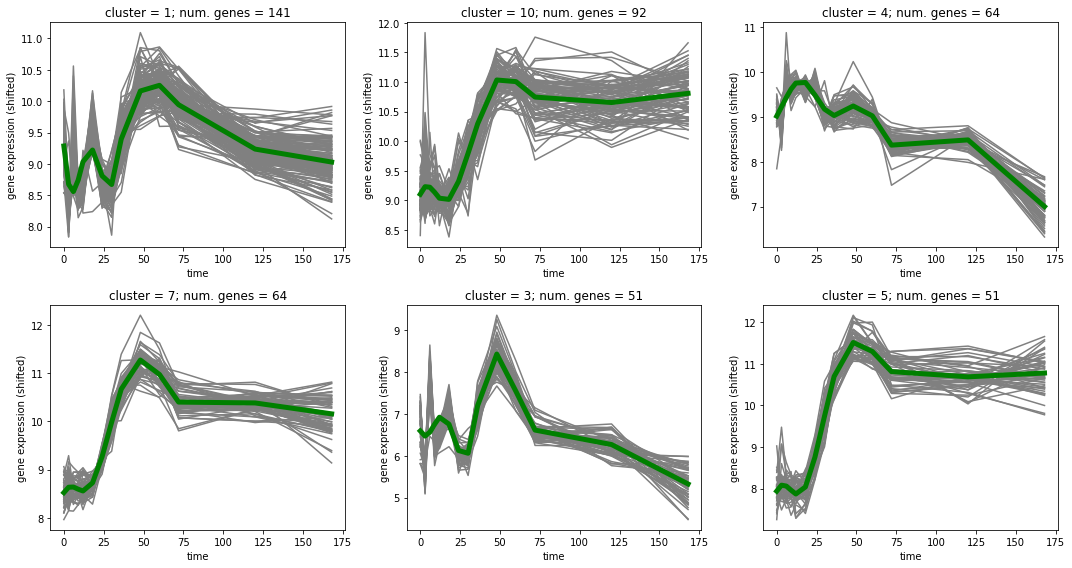

In [13]:
plot_top_clusters(vb_init_dict, ez_init)

# Functions to plot results

### Function to get optimal ez

In [14]:
def get_ez_opt(vb_free): 
    
    # this returns the expected individual memberships. 
        
    vb_params_dict = vb_params_paragami.fold(vb_free, free = True)
    
    ez = reg_posterior_quantities.get_optimal_local_params_from_vb_dict(genome_data,
                                                                        regressors,
                                                                        vb_params_dict,
                                                                        prior_params_dict, 
                                                                        gh_loc, gh_weights)[0]
    
    return ez

### plot co-clustering and diffs

In [15]:
def plot_coclustering(ez_refit, ez_lr, ez_init): 
    
    fig, ax = plt.subplots(1, 4, figsize = (16, 3))
    
    # compute co-clustering matrices
    
    # the init
    coclust_init = np.dot(ez_init, 
                          ez_init.transpose())
    
    # the refit
    coclust_refit = np.dot(ez_refit,
                           ez_refit.transpose())
    
    # the lr
    coclust_lr = np.dot(ez_lr,
                        ez_lr.transpose())
    
    # plot diff colormaps
    result_loading_utils.plot_colormaps(coclust_refit,
                                        coclust_lr,
                                        coclust_init,
                                        fig, ax[2:], 
                                        plot_initial = False)
    
    # plot diff in expected individual belongings
    result_loading_utils.print_diff_plot(ez_refit.flatten(), 
                                         ez_lr.flatten(),
                                         ez_init.flatten(), 
                                         ax[0],
                                         alpha = 0.05)
    
    
    # plot diff in coclustering
    result_loading_utils.print_diff_plot(coclust_refit.flatten(), 
                                         coclust_lr.flatten(),
                                         coclust_init.flatten(), 
                                         ax[1],
                                         alpha = 0.05)
    
    
    return fig, ax

In [16]:
@jax.jit
def get_diff_in_ez(vb_free): 
    vb_params_dict = vb_params_paragami.fold(vb_free, free = True)
    
    ez_pert = get_ez_opt(vb_free)
    
    ez_init = get_ez_opt(vb_init_free)
    
    return np.abs(ez_pert - ez_init).mean()

@jax.jit
def get_diff_in_coclustering(vb_free): 
    vb_params_dict = vb_params_paragami.fold(vb_free, free = True)
    
    ez_pert = get_ez_opt(vb_free)
    coclust_matr = np.dot(ez_pert, ez_pert.transpose())
    
    ez_init = get_ez_opt(vb_init_free)
    coclust_matr0 = np.dot(ez_init, ez_init.transpose())
    
    return np.abs(coclust_matr - coclust_matr0).mean()

### wrapper to plot results for a given perturbation

In [17]:
def plot_results_for_perturbation(perturbation, delta, epsilon_indx_vec = [-1]): 
    
    #################
    # load free parameters
    #################
    vb_refit_list, lr_list, epsilon_vec = \
        gmm_result_loader.get_free_param_results_from_perturbation(perturbation, delta)
    assert (vb_refit_list[0] == lr_list[0]).all()
    
    #################
    # see how our summary statistic changes
    #################
    fig, ax = plt.subplots(1, 3, figsize = (12, 3))
    result_loading_utils.plot_post_stat_per_epsilon(get_diff_in_ez, 
                                                    vb_refit_list,
                                                    lr_list,
                                                    epsilon_vec,
                                                    ax[0])
    ax[0].set_ylabel('median. abs. error in ez')
    
    result_loading_utils.plot_post_stat_per_epsilon(get_diff_in_coclustering, 
                                                    vb_refit_list,
                                                    lr_list,
                                                    epsilon_vec,
                                                    ax[1])
    ax[1].set_ylabel('median. abs. error in coclust')
    ax[0].legend()
    
    for a in ax: 
        for eps_indx in epsilon_indx_vec: 
            a.axvline(epsilon_vec[eps_indx],
                       color = 'grey',
                       linestyle = 'dashed')
    fig.tight_layout()
    
    ###############
    # initial ez and coclustering
    ###############
    ez_init = get_ez_opt(vb_refit_list[0])[ez_perm]
    coclust_init = np.dot(ez_init, ez_init.transpose())
    ax[2].set_title('initial coclustering')
    im0 = ax[2].matshow(coclust_init, 
                        cmap = plt.get_cmap('Blues'))
    fig.colorbar(im0, ax = ax[2])

    for eps_indx in epsilon_indx_vec: 
        #################
        # get ezs
        #################
        ez_refit = get_ez_opt(vb_refit_list[eps_indx])[ez_perm]
        ez_lr = get_ez_opt(lr_list[eps_indx])[ez_perm]

        #####################
        # plot co-clustering
        #####################
        fig, ax = plot_coclustering(ez_refit, ez_lr, ez_init)
        ax[0].set_title('diff in ez; epsilon = {:.03f}'.format(epsilon_vec[eps_indx]))
        ax[1].set_title('diff in coclust; epsilon = {:.03f}'.format(epsilon_vec[eps_indx]))
    
        fig.tight_layout()

# Sigmoidal perturbations

/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:259: AccuracyWarning: maxiter (50) exceeded. Latest difference = 9.388126e-08
  warnings.warn(


Optim time at epsilon = 1: 63.218secs
Derivative time: 4.507secs


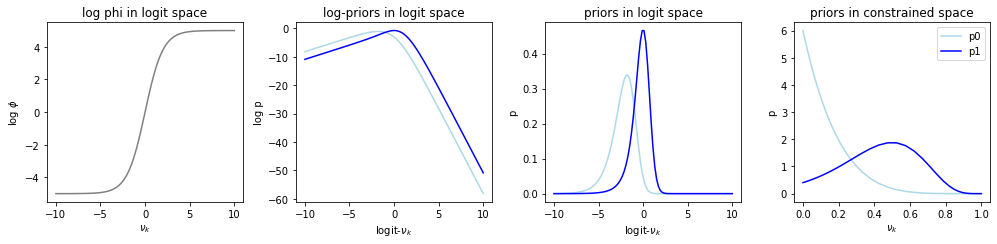

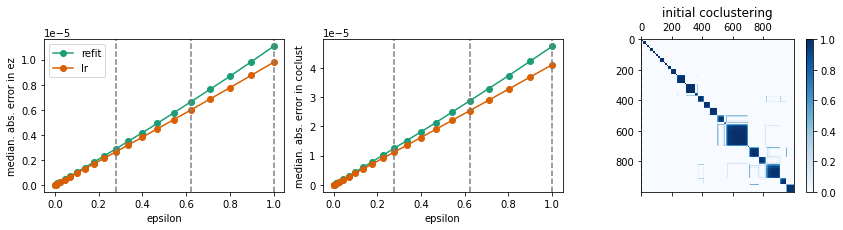

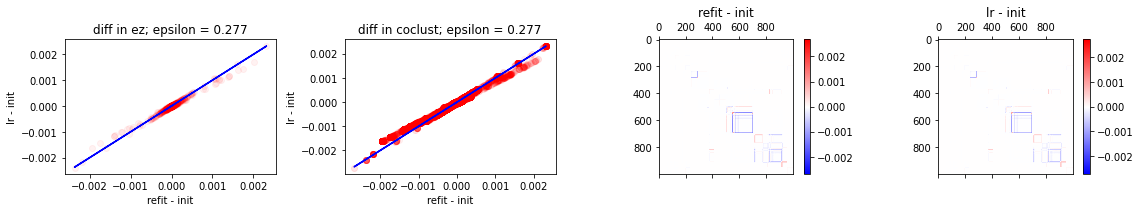

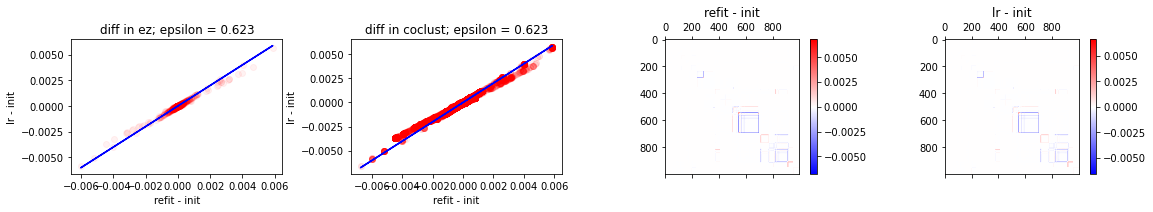

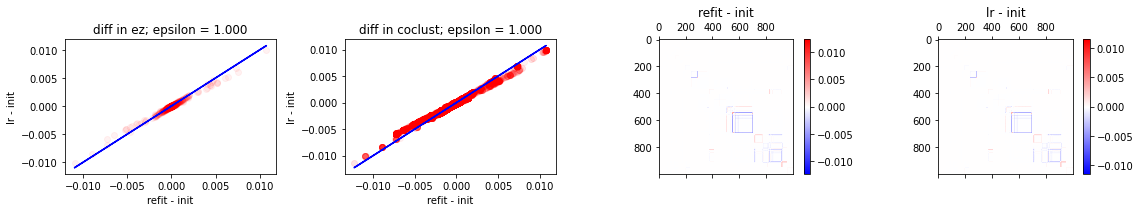

In [18]:
delta = 5
perturbation = 'sigmoidal'

result_loading_utils.plot_perturbation(perturbation, delta, alpha0)

plot_results_for_perturbation(perturbation, 
                              delta, 
                              [10, 15, -1])

Optim time at epsilon = 1: 59.235secs
Derivative time: 4.507secs


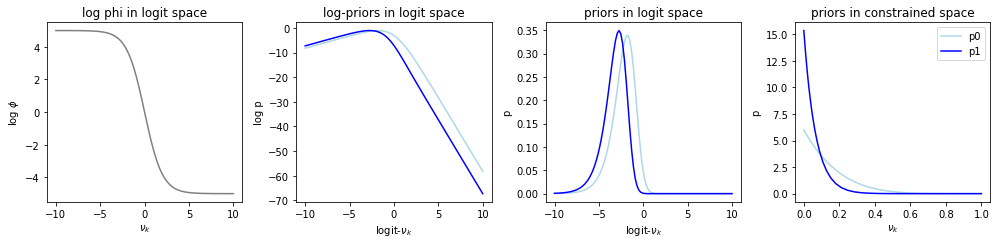

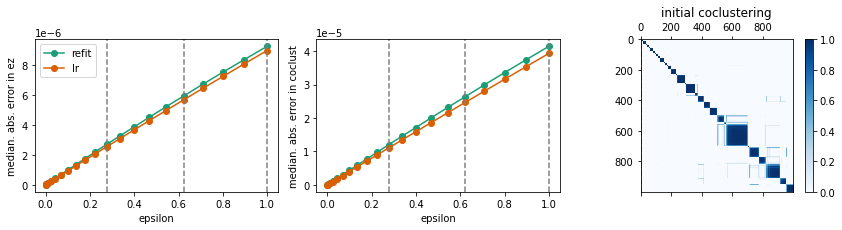

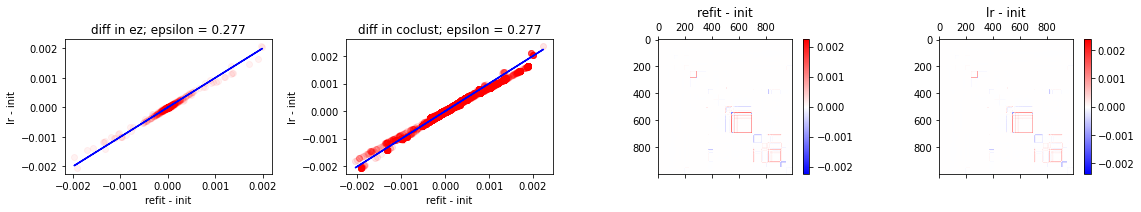

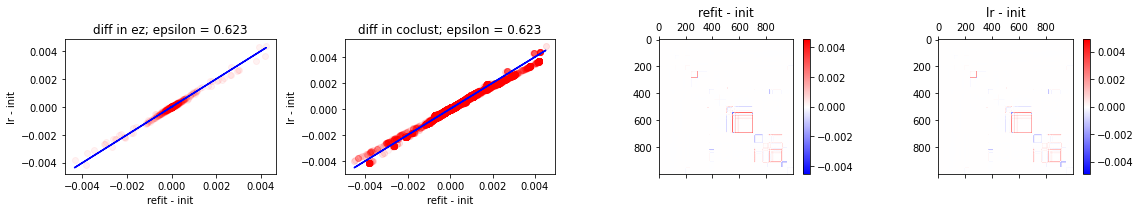

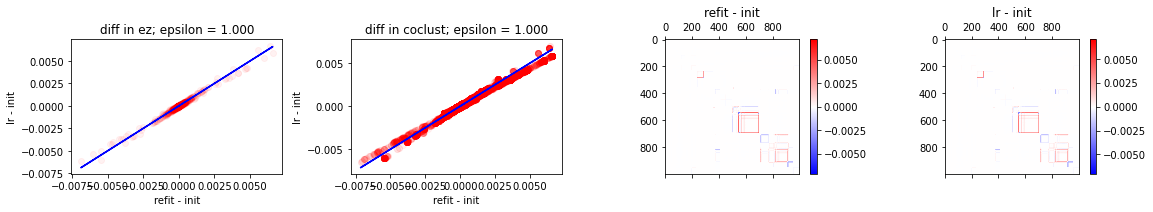

In [19]:
delta = -5
perturbation = 'sigmoidal'

result_loading_utils.plot_perturbation(perturbation, delta, alpha0)

plot_results_for_perturbation(perturbation, 
                              delta, 
                              [10, 15, -1])

# Alpha-type perturbations

Optim time at epsilon = 1: 28.498secs
Derivative time: 3.733secs


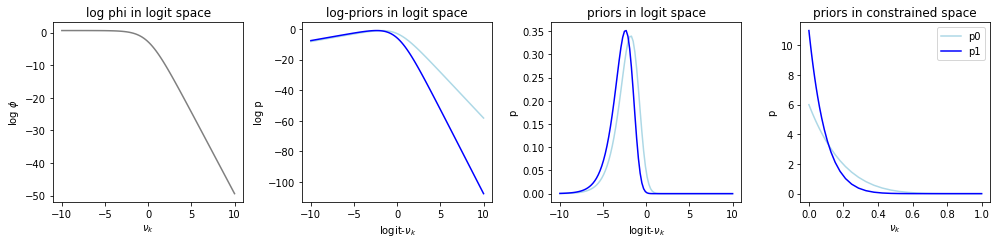

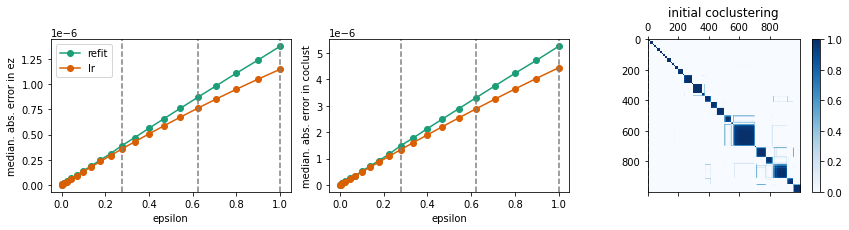

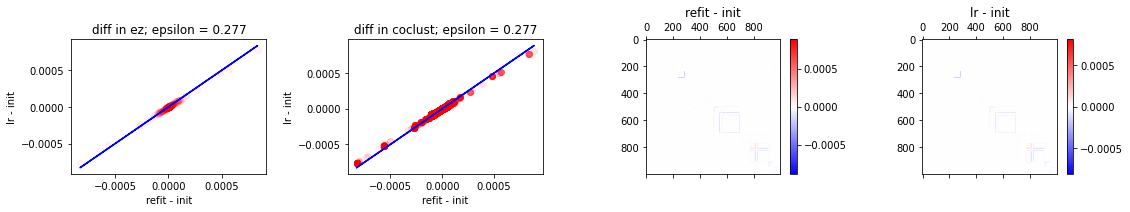

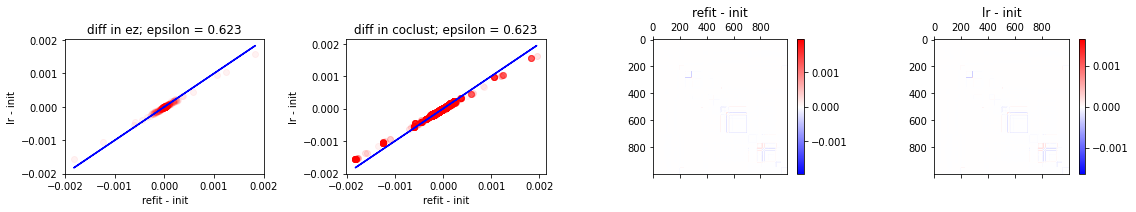

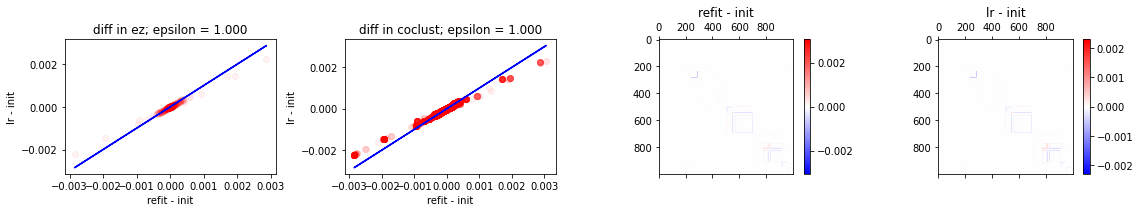

In [20]:
delta = 1
perturbation = 'alpha_pert_pos'

result_loading_utils.plot_perturbation(perturbation, delta, alpha0)

plot_results_for_perturbation(perturbation, 
                              delta, 
                              [10, 15, -1])

Optim time at epsilon = 1: 26.310secs
Derivative time: 3.590secs


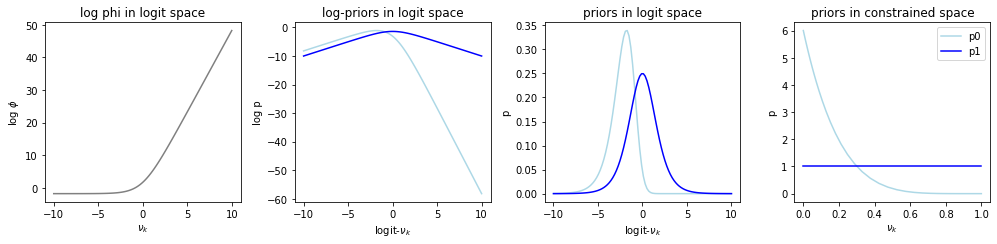

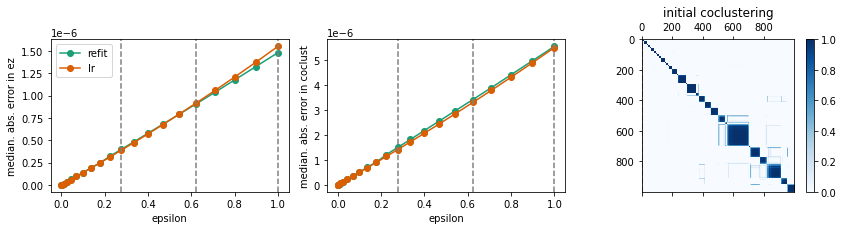

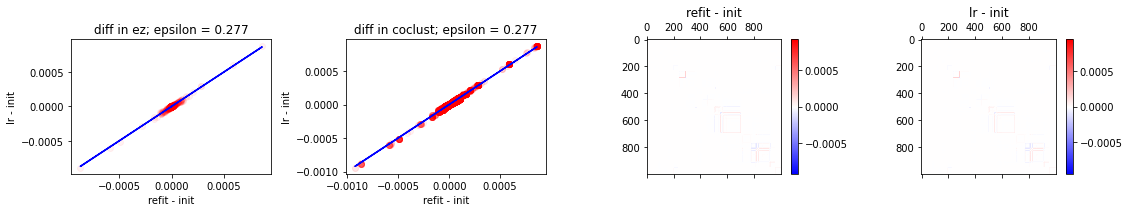

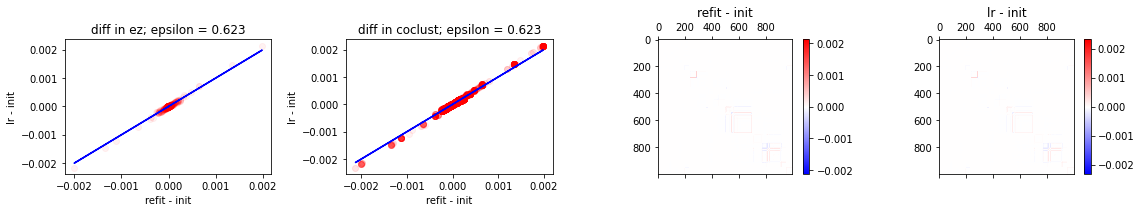

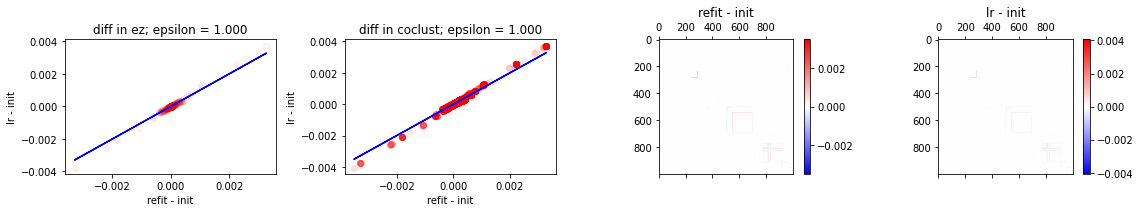

In [21]:
delta = 1
perturbation = 'alpha_pert_neg'

result_loading_utils.plot_perturbation(perturbation, delta, alpha0)

plot_results_for_perturbation(perturbation, 
                              delta, 
                              [10, 15, -1])

# Gaussian bumps

/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:259: AccuracyWarning: maxiter (50) exceeded. Latest difference = 1.362176e-04
  warnings.warn(


Optim time at epsilon = 1: 39.279secs
Derivative time: 3.669secs


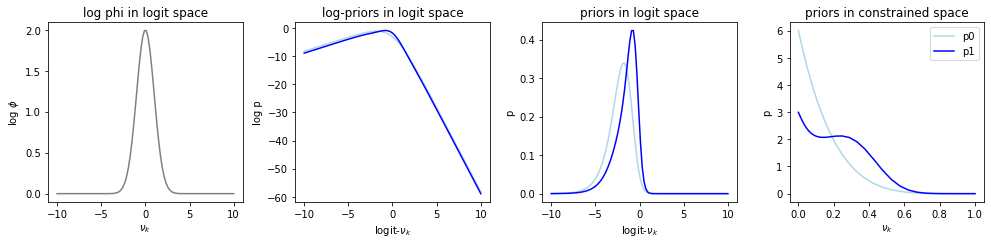

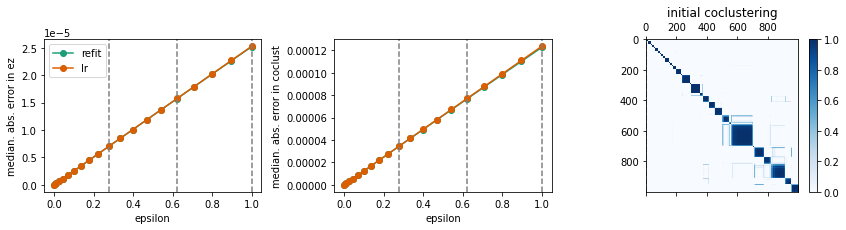

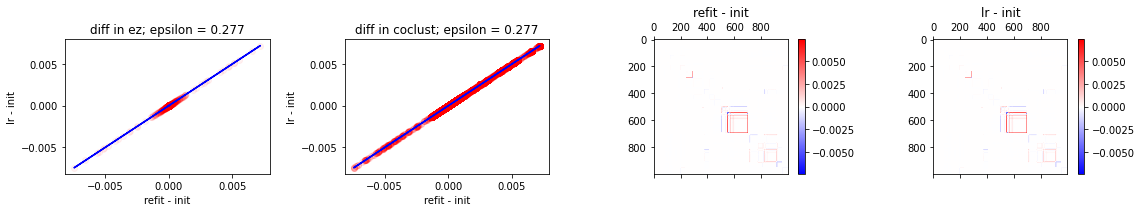

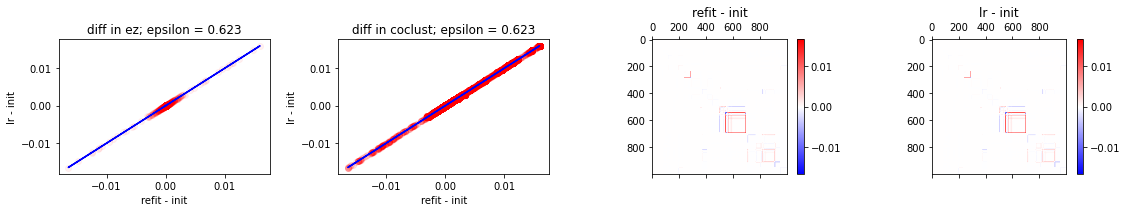

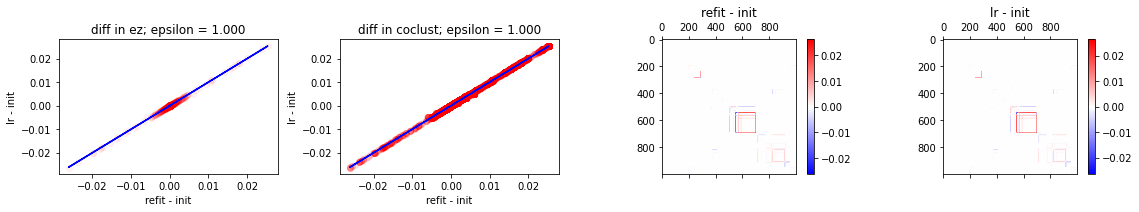

In [22]:
delta = 2
perturbation = 'gauss_pert1'

result_loading_utils.plot_perturbation(perturbation, delta, alpha0)

plot_results_for_perturbation(perturbation, 
                              delta, 
                              [10, 15, -1])

/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:259: AccuracyWarning: maxiter (50) exceeded. Latest difference = 1.070934e-06
  warnings.warn(


Optim time at epsilon = 1: 47.283secs
Derivative time: 3.669secs


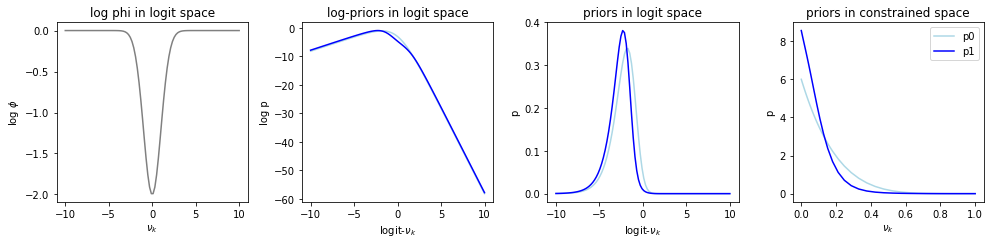

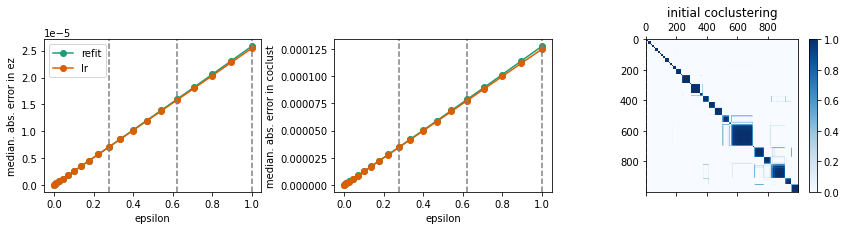

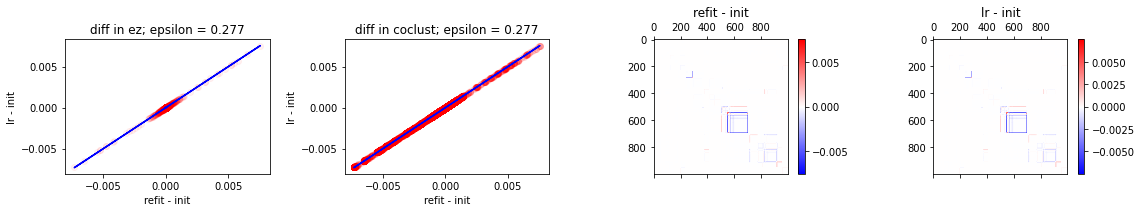

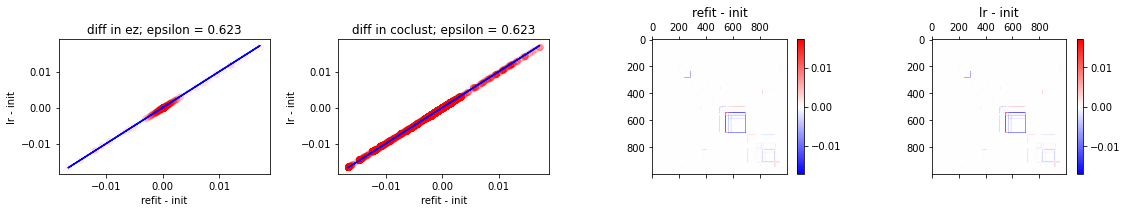

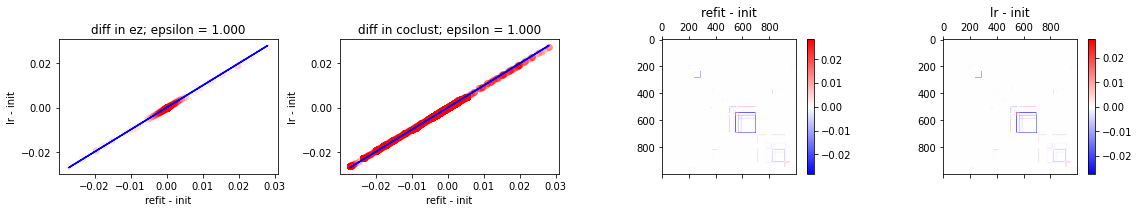

In [23]:
delta = -2
perturbation = 'gauss_pert1'

result_loading_utils.plot_perturbation(perturbation, delta, alpha0)

plot_results_for_perturbation(perturbation, 
                              delta, 
                              [10, 15, -1])

/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:259: AccuracyWarning: maxiter (50) exceeded. Latest difference = 4.091173e-05
  warnings.warn(


Optim time at epsilon = 1: 48.034secs
Derivative time: 4.616secs


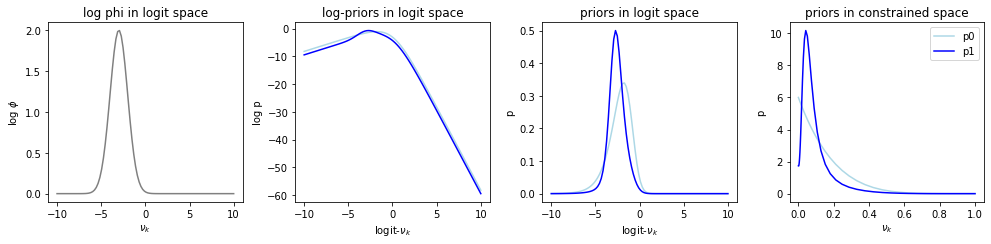

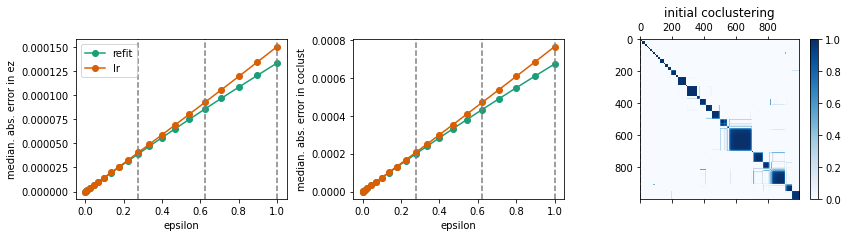

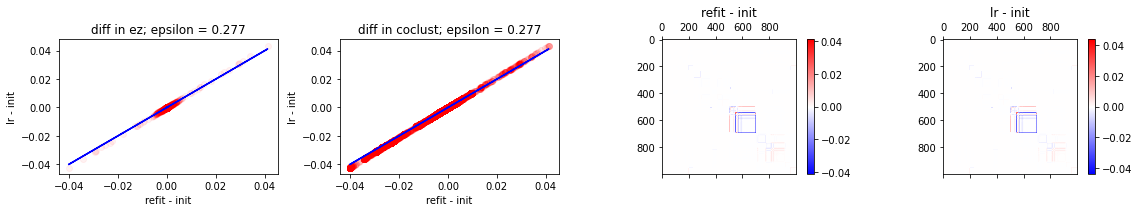

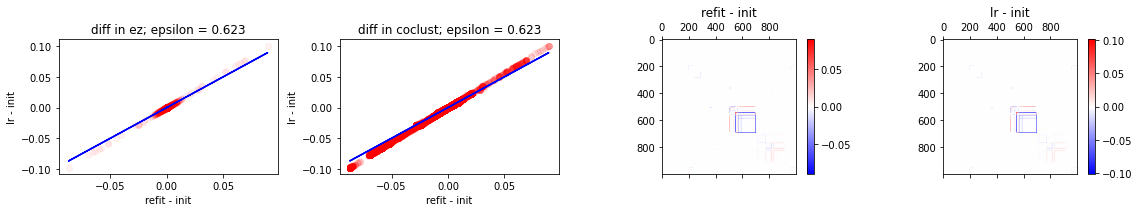

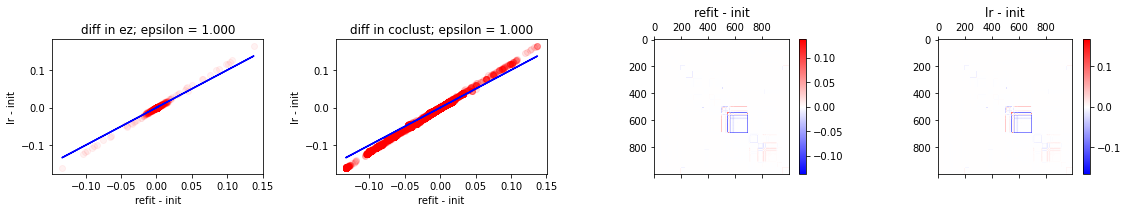

In [24]:
delta = 2
perturbation = 'gauss_pert2'

result_loading_utils.plot_perturbation(perturbation, delta, alpha0)

plot_results_for_perturbation(perturbation, 
                              delta, 
                              [10, 15, -1])

/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:259: AccuracyWarning: maxiter (50) exceeded. Latest difference = 1.327195e-07
  warnings.warn(
/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:259: AccuracyWarning: maxiter (50) exceeded. Latest difference = 9.136652e-07
  warnings.warn(


Optim time at epsilon = 1: 41.704secs
Derivative time: 4.616secs


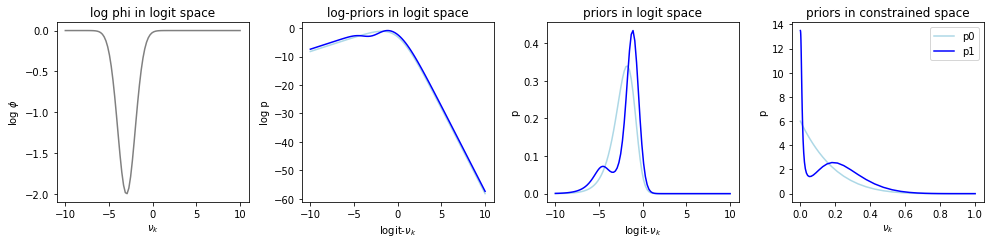

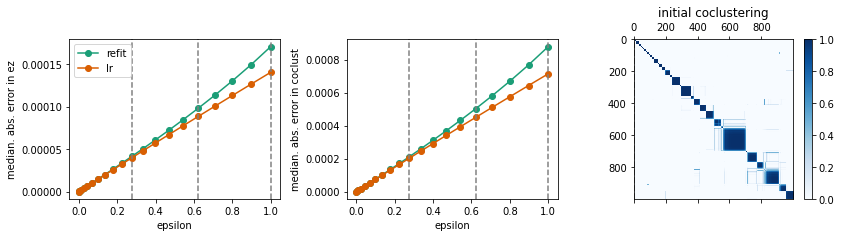

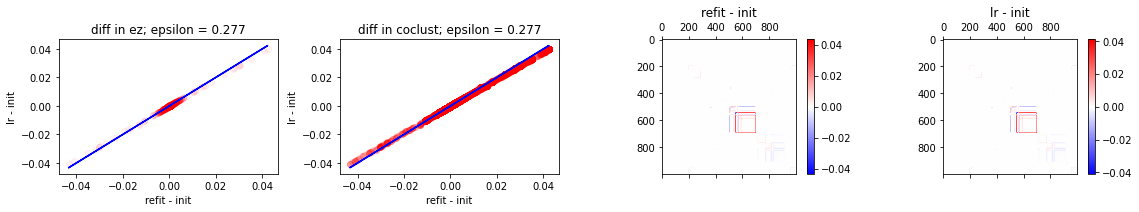

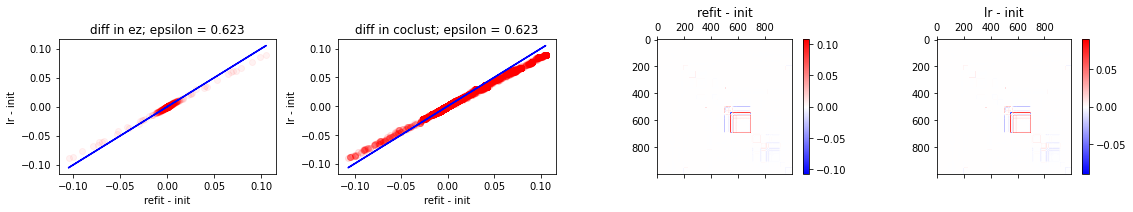

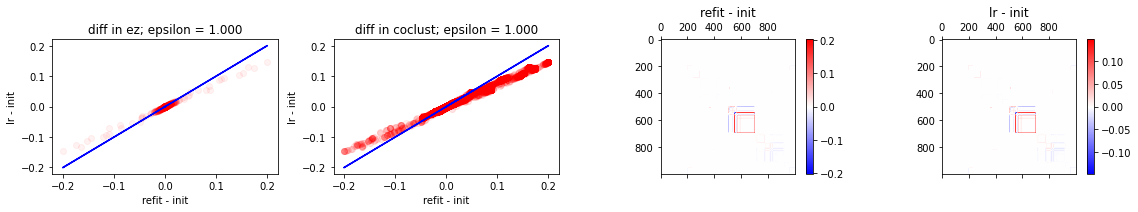

In [25]:
delta = -2
perturbation = 'gauss_pert2'

result_loading_utils.plot_perturbation(perturbation, delta, alpha0)

plot_results_for_perturbation(perturbation, 
                              delta, 
                              [10, 15, -1])